In [292]:
# If in Colab, uncomment:
# !pip install torch torchvision matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [293]:
# Saliency Model
class SaliencyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 1, 1, padding=0)
        )
    
    def forward(self, x):
        return self.features(x)

In [294]:
g_patch_size = 9
g_image_size = 28
g_patch_count = 5
channel_count = 1

In [295]:
# Reconstructor Network
class PatchReconstructor(nn.Module):
    def __init__(self, patch_count=g_patch_count, patch_size=g_patch_size, image_size=g_image_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(patch_count * channel_count * patch_size * patch_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, channel_count * image_size * image_size),
        )
        self.image_size = image_size

    def forward(self, patches):
        batch = patches.shape[0] // 5
        patches = patches.view(batch, -1)
        out = self.fc(patches)
        return out.view(-1, 1, self.image_size, self.image_size)

In [296]:
def extract_topk_patches(image, heatmap, patch_size=g_patch_size, k=g_patch_count):
    b, _, h, w = heatmap.shape
    flat = heatmap.view(b, -1)
    topk_vals, topk_indices = flat.topk(k, dim=1)

    patches = []
    for i in range(b):
        img = image[i]
        for idx in topk_indices[i]:
            y = (idx // w).item()
            x = (idx % w).item()
            y1 = max(0, y - patch_size // 2)
            x1 = max(0, x - patch_size // 2)
            patch = img[:, y1:y1+patch_size, x1:x1+patch_size]
            patch = F.interpolate(patch.unsqueeze(0), size=(patch_size, patch_size), mode='bilinear')
            patches.append(patch)
    return torch.cat(patches, dim=0)

In [297]:
transform = T.Compose([
    T.Resize((g_image_size, g_image_size)),
    T.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [298]:
saliency_model = SaliencyCNN()
reconstructor = PatchReconstructor()
params = list(saliency_model.parameters()) + list(reconstructor.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(1):
    for images, _ in dataloader:
        optimizer.zero_grad()
        heatmap = saliency_model(images)
        patches = extract_topk_patches(images, heatmap, patch_size=g_patch_size, k=5)
        reconstructed = reconstructor(patches)
        loss = loss_fn(reconstructed, images)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

Epoch 1 | Loss: 0.0635


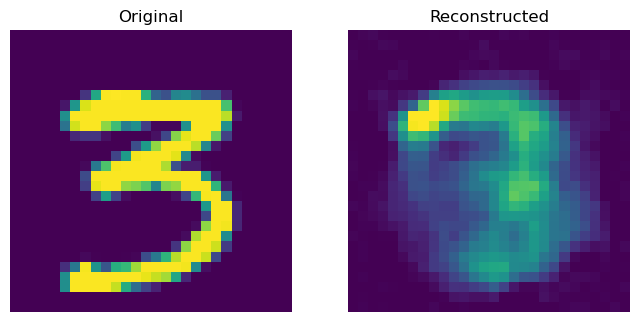

In [327]:
def show_result(original, reconstructed):
    original = original[0].permute(1, 2, 0).detach().numpy()
    reconstructed = reconstructed[0].permute(1, 2, 0).detach().numpy()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(original)
    axs[0].set_title("Original")
    axs[1].imshow(np.clip(reconstructed, 0, 1))
    axs[1].set_title("Reconstructed")
    for ax in axs: ax.axis('off')
    plt.show()

images, _ = next(iter(dataloader))
with torch.no_grad():
    heatmap = saliency_model(images)
    patches = extract_topk_patches(images, heatmap, patch_size=g_patch_size, k=5)
    reconstructed = reconstructor(patches)

show_result(images, reconstructed)

In [328]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Saliency Model
class SaliencyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 1, 1, padding=0)
        )
    
    def forward(self, x):
        return self.features(x)

g_patch_size = 9
g_image_size = 28
g_patch_count = 5
channel_count = 1

# Reconstructor Network
class PatchReconstructor(nn.Module):
    def __init__(self, patch_count=g_patch_count, patch_size=g_patch_size, image_size=g_image_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(patch_count * channel_count * patch_size * patch_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, channel_count * image_size * image_size),
        )
        self.image_size = image_size

    def forward(self, patches):
        batch = patches.shape[0] // g_patch_count
        patches = patches.view(batch, -1)
        out = self.fc(patches)
        return out.view(-1, 1, self.image_size, self.image_size)

# Perceptual Loss Model
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

def extract_topk_patches(image, heatmap, patch_size=g_patch_size, k=g_patch_count):
    b, _, h, w = heatmap.shape
    flat = heatmap.view(b, -1)
    topk_vals, topk_indices = flat.topk(k, dim=1)

    patches = []
    for i in range(b):
        img = image[i]
        for idx in topk_indices[i]:
            y = (idx // w).item()
            x = (idx % w).item()
            y1 = max(0, y - patch_size // 2)
            x1 = max(0, x - patch_size // 2)
            patch = img[:, y1:y1+patch_size, x1:x1+patch_size]
            patch = F.interpolate(patch.unsqueeze(0), size=(patch_size, patch_size), mode='bilinear')
            noise = 0.1 * torch.randn_like(patch)
            patches.append(patch + noise)
    return torch.cat(patches, dim=0)

transform = T.Compose([
    T.Resize((g_image_size, g_image_size)),
    T.ToTensor(),
])


In [329]:
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

saliency_model = SaliencyCNN()
reconstructor = PatchReconstructor()
feature_extractor = FeatureExtractor()

params = list(saliency_model.parameters()) + list(reconstructor.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)
recon_loss_fn = nn.MSELoss()
feature_loss_fn = nn.MSELoss()

In [330]:
for epoch in range(1):
    for images, _ in dataloader:
        optimizer.zero_grad()

        # Forward pass
        heatmap = saliency_model(images)
        patches = extract_topk_patches(images, heatmap)
        reconstructed = reconstructor(patches)

        # Clamp output for safety
        reconstructed_clamped = reconstructed.clamp(0, 1)

        # Pixel (reconstruction) loss
        recon_loss = recon_loss_fn(reconstructed_clamped, images)

        # Perceptual loss
        with torch.no_grad():
            real_features = feature_extractor(images)
        recon_features = feature_extractor(reconstructed_clamped)
        perceptual_loss = feature_loss_fn(recon_features, real_features)

        # Diversity loss (cosine dissimilarity)
        flat = reconstructed_clamped.view(reconstructed_clamped.size(0), -1)
        sim_matrix = F.cosine_similarity(flat.unsqueeze(1), flat.unsqueeze(0), dim=2)
        mask = 1 - torch.eye(flat.size(0), device=sim_matrix.device)
        diversity_loss = 1 - (sim_matrix * mask).sum() / mask.sum()

        # Total loss
        total_loss = recon_loss + 0.5 * perceptual_loss + 0.1 * diversity_loss
        total_loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} | Recon: {recon_loss.item():.4f} | Perceptual: {perceptual_loss.item():.4f} | Diversity: {diversity_loss.item():.4f} | Total: {total_loss.item():.4f}")


Epoch 1 | Recon: 0.0640 | Perceptual: 0.0035 | Diversity: 0.0147 | Total: 0.0672


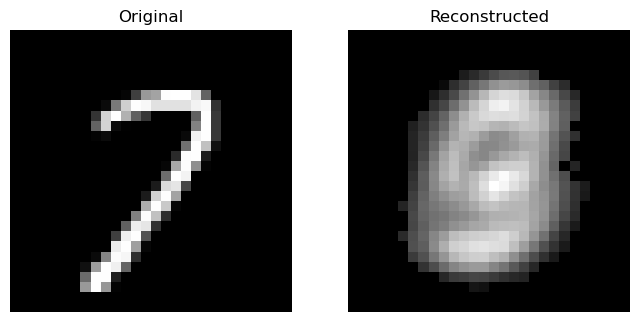

In [371]:
def show_result(original, reconstructed):
    original = original[0].permute(1, 2, 0).detach().numpy()
    reconstructed = reconstructed[0].permute(1, 2, 0).detach().numpy()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(original.squeeze(), cmap='gray')
    axs[0].set_title("Original")
    axs[1].imshow(np.clip(reconstructed.squeeze(), 0, 1), cmap='gray')
    axs[1].set_title("Reconstructed")
    for ax in axs: ax.axis('off')
    plt.show()

images, _ = next(iter(dataloader))
with torch.no_grad():
    heatmap = saliency_model(images)
    patches = extract_topk_patches(images, heatmap)
    reconstructed = reconstructor(patches)

show_result(images, reconstructed)
